In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

import os, sys
sys.path.append("..")

from lammpsrun import *
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule, bcc110, bcc111
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
print(cx1_out + '\n' + sim_path)

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


# Building the box

## Creating the simulation box particles

In [2]:
aq_thickness = 25

In [3]:
Fe_bcc111_l10 = bcc111('Fe', size=(4,4,10), orthogonal=True, vacuum=aq_thickness)
Fe_bcc111_l10.center()

In [8]:
[aq_thickness]

[25]

In [7]:
Fe_bcc111_l10.get_cell_lengths_and_angles()

array([16.2351717 , 14.06007112, 57.45647873, 90.        , 90.        ,
       90.        ])

In [5]:
aq_cell_l10 = list(diagonal(Fe_bcc111_l10.get_cell()[:-1, :-1])) + [aq_thickness]
assert sum(Fe_bcc111_l10.get_cell()[:-1, :-1]) == sum(aq_cell_l10[:2])
H2O_l10 = create_water_region(aq_cell_l10)

H2O_l10_upper = H2O_l10.copy()
H2O_l10_upper.translate([0, 0, Fe_bcc111_l10.get_cell_lengths_and_angles()[2]-aq_thickness])
H2O_l10_lower = H2O_l10.copy()

Fe_bcc111_l10_aq = Fe_bcc111_l10 + H2O_l10_upper + H2O_l10_lower
Fe_bcc111_l10_aq.set_pbc(True)
Fe_bcc111_l10_aq

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

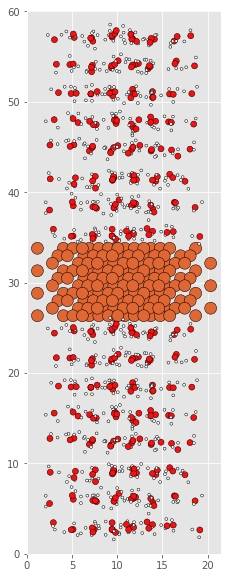

In [11]:
#style.use('dark_background')
style.use('ggplot')
figure(figsize=(18, 10))
plot_atoms(Fe_bcc111_l10_aq, radii=0.5, rotation=('90x,45y,0z'))
Fe_bcc111_l10_aq.write(sim_path + "fe_aq/Fe_bcc111_l10_aq.extxyz")
show()

In [19]:
Fe_aq_list_of_elements = sorted(list(set(Fe_bcc111_l10_aq.get_chemical_symbols())))
Fe_aq_potential = 'ffield.reax.Fe_O_C_H_combined'
Fe_aq_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 {0}".format(atomic_masses[atomic_numbers[Fe_aq_list_of_elements[0]]]),
             "2 {0}".format(atomic_masses[atomic_numbers[Fe_aq_list_of_elements[1]]]),
             "3 {0}".format(atomic_masses[atomic_numbers[Fe_aq_list_of_elements[2]]])],
    "velocity": ["all create 300.0 1050027 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + '{0} '.format(Fe_aq_potential) + ' '.join(Fe_aq_list_of_elements)],
    "neighbor": "2.0 bin",
    "neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "100000",
    "timestep": 0.25,
    "fix": ["1 all nve",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]#,
            #"2 all temp/berendsen 300.0 300.0 100"]
}

In [12]:
Fe_bcc111_l10_aq_calc = LAMMPS(parameters=Fe_aq_reaxff_params, no_data_file=True, always_triclinic=True)

Fe_bcc111_l10_aq.set_calculator(Fe_bcc111_l10_aq_calc)
Fe_bcc111_l10_aq_calc.atoms = Fe_bcc111_l10_aq.copy()
Fe_bcc111_l10_aq_calc.prism = Prism(Fe_bcc111_l10_aq_calc.atoms.get_cell())

In [15]:
Fe_bcc111_l10_aq_calc.write_lammps_in(lammps_in=sim_path+"fe_aq/Fe_bcc111_l10_aq_300K.in",
                                      lammps_trj="Fe_bcc111_l10_aq.lammpstrj")

In [19]:
Fe_bcc111_l10_aq_PBS = PBS_Submitter(job_names="Fe_bcc111_l10_aq_300K",
                                     job_commands="mpiexec lmp_mpi -in Fe_bcc111_l10_aq_300K.in -screen none",
                                     modules=["mpi", "lammps", "intel-suite/2017.6"],
                                     walltime="4:00:00",
                                     proc_nodes=1,
                                     proc_cpus=8,
                                     proc_mpiprocs=8,
                                     memory=4,
                                     source_files=['$HOME/LAMMPS_Simulation/potentials/{0}'.format(Fe_aq_potential),
                                                  '$PBS_O_WORKDIR/Fe_bcc111_l10_aq_300K.in'])
Fe_bcc111_l10_aq_PBS.params

{'source_files': [['$HOME/LAMMPS_Simulation/potentials/ffield.reax.Fe_O_C_H_combined',
   '$PBS_O_WORKDIR/Fe_bcc111_l10_aq_300K.in']],
 'job_names': ['Fe_bcc111_l10_aq_300K'],
 'job_commands': ['mpiexec lmp_mpi -in Fe_bcc111_l10_aq_300K.in -screen none'],
 'modules': [['mpi', 'lammps', 'intel-suite/2017.6']],
 'walltime': ['4:00:00'],
 'proc_nodes': [1],
 'proc_cpus': [8],
 'proc_mpiprocs': [8],
 'memory': [4]}

In [20]:
curr_dir = os.getcwd()
os.chdir(sim_path + "fe_aq")

Fe_bcc111_l10_aq_out, Fe_bcc111_l10_aq_err = Fe_bcc111_l10_aq_PBS.run()

os.chdir(curr_dir)

In [ ]:
qstat_monitor()

In [40]:
# Move all the log and error files over to the jobs directory
!mv {sim_path}fe_aq/Fe_bcc111_l10_aq_300K.* {cx1_out}{Fe_bcc111_l10_aq_out[0]}/

mv: cannot stat ‘/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/fe_aq/Fe_bcc111_l10_aq_300K.*’: No such file or directory


In [24]:
# Converting lammpstrj to ase traj
Fe_bcc111_l10_aq_calc.trajectory_out = Trajectory(sim_path + "fe_aq/Fe_bcc111_l10_aq.traj", 'w')
Fe_bcc111_l10_aq_calc.read_lammps_trj(lammps_trj = cx1_out + Fe_bcc111_l10_aq_out[0] + r"/Fe_bcc111_l10_aq.lammpstrj")
Fe_bcc111_l10_aq_calc.trajectory_out.close()

In [22]:
Fe_bcc111_l10_aq_traj = Trajectory(sim_path + "fe_aq/aq_300K.traj", 'r')

In [26]:
Fe_bcc111_l10_aq

Atoms(symbols='H640Fe160O320', pbc=True, cell=[16.235171696043132, 14.060071123575442, 57.45647872658402], tags=..., calculator=LAMMPS(...))

# Try again with fix efield

In [29]:
# paper used 25 MeV /cm ???
# Alternative source used 10MV /cm is needed DOI: 10.1039/C2CP43490C
# real units volts/Angstrom

In [16]:
Fe_bcc111_l30 = bcc111('Fe', size=(4,4,30), orthogonal=True, vacuum=aq_thickness)
Fe_bcc111_l30.center()

In [17]:
aq_cell_l30 = list(diagonal(Fe_bcc111_l30.get_cell()[:-1, :-1])) + [aq_thickness]
assert sum(Fe_bcc111_l30.get_cell()[:-1, :-1]) == sum(aq_cell_l30[:2])
H2O_l30 = create_water_region(aq_cell_l30)

H2O_l30_upper = H2O_l30.copy()
H2O_l30_upper.translate([0, 0, Fe_bcc111_l30.get_cell_lengths_and_angles()[2]-aq_thickness])
H2O_l30_lower = H2O_l30.copy()

Fe_bcc111_l30_aq = Fe_bcc111_l30 + H2O_l30_upper + H2O_l30_lower
Fe_bcc111_l30_aq.set_pbc(True)
Fe_bcc111_l30_aq

Atoms(symbols='H640Fe480O320', pbc=True, cell=[16.235171696043132, 14.060071123575442, 74.02643145232628], tags=...)

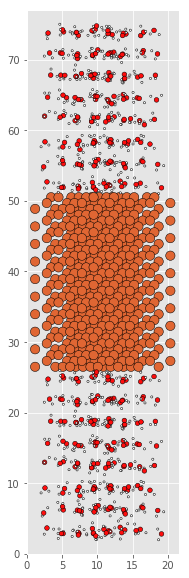

In [19]:
#style.use('dark_background')
style.use('ggplot')
figure(figsize=(18, 10))
plot_atoms(Fe_bcc111_l30_aq, radii=0.5, rotation=('90x,45y,0z'))
Fe_bcc111_l10_aq.write(sim_path + "fe_aq/Fe_bcc111_l30_aq.extxyz")
show()

In [20]:
Fe_aq_list_of_elements = sorted(list(set(Fe_bcc111_l10_aq.get_chemical_symbols())))
Fe_aq_potential = 'ffield.reax.Fe_O_C_H_combined'
Fe_aq_efield_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 {0}".format(atomic_masses[atomic_numbers[Fe_aq_list_of_elements[0]]]),
             "2 {0}".format(atomic_masses[atomic_numbers[Fe_aq_list_of_elements[1]]]),
             "3 {0}".format(atomic_masses[atomic_numbers[Fe_aq_list_of_elements[2]]])],
    "velocity": ["all create 300.0 1050027 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + '{0} '.format(Fe_aq_potential) + ' '.join(Fe_aq_list_of_elements)],
    "neighbor": "2.0 bin",
    "neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "50000",
    "timestep": 0.1,
    "fix": ["all_nve all nve",
            "reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c",
            "elec all efield 0.0 0.0 2.0"]
}

In [30]:
Fe_bcc111_l30_aq_efield = Fe_bcc111_l30_aq.copy()
Fe_bcc111_l30_aq_efield_names = ["Fe_bcc111_l30_aq_efield_300K"]
Fe_bcc111_l30_aq_efield_input = ["{0}.in".format(x) for x in Fe_bcc111_l30_aq_efield_names]
Fe_bcc111_l30_aq_efield_commands = ["mpiexec lmp_mpi -in {0} -screen none\n".format(x) for x in Fe_bcc111_l30_aq_efield_input]
Fe_bcc111_l30_aq_efield_source_files = ['$HOME/LAMMPS_Simulation/potentials/{0}'.format(Fe_aq_potential)]+['$PBS_O_WORKDIR/'+x for x in Fe_bcc111_l30_aq_efield_input]

In [32]:
Fe_bcc111_l30_aq_efield_calc = LAMMPS(parameters=Fe_aq_efield_reaxff_params, no_data_file=True, always_triclinic=True)

Fe_bcc111_l30_aq_efield.set_calculator(Fe_bcc111_l30_aq_efield_calc)
Fe_bcc111_l30_aq_efield_calc.atoms = Fe_bcc111_l30_aq_efield.copy()
Fe_bcc111_l30_aq_efield_calc.prism = Prism(Fe_bcc111_l30_aq_efield_calc.atoms.get_cell())

Fe_bcc111_l30_aq_efield_calc.write_lammps_in(lammps_in=sim_path+"fe_aq/Fe_bcc111_l30_aq_efield_300K.in",
                                             lammps_trj="Fe_bcc111_l30_aq_efield.lammpstrj")

Fe_bcc111_l30_aq_efield_PBS = PBS_Submitter(job_names=Fe_bcc111_l30_aq_efield_names,
                                            job_commands=Fe_bcc111_l30_aq_efield_commands,
                                            modules=["mpi", "lammps", "intel-suite/2017.6"],
                                            walltime="12:00:00",
                                            proc_nodes=1,
                                            proc_cpus=8,
                                            proc_mpiprocs=8,
                                            memory=4,
                                            source_files=Fe_bcc111_l30_aq_efield_source_files)

In [33]:
curr_dir = os.getcwd()
os.chdir(sim_path + "fe_aq")

Fe_bcc111_l30_aq_efield_out, Fe_bcc111_l30_aq_efield_err = Fe_bcc111_l30_aq_efield_PBS.run()

os.chdir(curr_dir)

In [ ]:
qstat_monitor(update_frequency=5, jobs_list=Fe_bcc111_l30_aq_efield_out)

           JobID        Job Name            User         Runtime          Status           Queue
     2143993.cx1 Fe_bcc111_l30_a          yx6015        07:08:40               R v1_throughput24
Running...


In [4]:
Fe_bcc111_l10

Atoms(symbols='Fe160', pbc=[True, True, False], cell=[16.235171696043132, 14.060071123575442, 57.45647872658402], tags=...)

In [5]:
write_lammps_data('test.lammpsdata', Fe_bcc111_l10)

- It has been noticed that applying electric does not conserve energy, at least not in this particular instance.

In [ ]:
# Converting lammpstrj to ase traj
Fe_bcc111_l30_aq_efield_calc.trajectory_out = Trajectory(sim_path + "fe_aq/Fe_bcc111_l30_aq_efield.traj", 'w')
Fe_bcc111_l30_aq_efield_calc.read_lammps_trj(lammps_trj = cx1_out + Fe_bcc111_l30_aq_efield_out[0] + r"/Fe_bcc111_l30_aq_efield.lammpstrj")
Fe_bcc111_l30_aq_efield_calc.trajectory_out.close()

In [ ]:
# Move all the log and error files over to the jobs directory
!mv {sim_path}fe_aq/Fe_bcc111_l30_aq_efield_300K.* {cx1_out}{Fe_bcc111_l30_aq_efield_out[0]}/

# Replicating the experimental conditions

In [2]:
Fe_bcc111_l40 = bcc111('Fe', size=(8,8,32), orthogonal=True, vacuum=1)
Fe_bcc111_l40.set_cell(Fe_bcc111_l40.get_cell() + array([[0,0,0],[0,0,0],[0,0,100]]))

In [3]:
aq_cell_l40 = list(diagonal(Fe_bcc111_l40.get_cell()[:-1, :-1])) + [100]
assert sum(Fe_bcc111_l40.get_cell()[:-1, :-1]) == sum(aq_cell_l40[:2])
H2O_l40 = create_water_region(aq_cell_l40)

H2O_l40.translate([0, 0, Fe_bcc111_l40.get_cell()[-1, -1]-100])

Fe_bcc111_l40_aq = Fe_bcc111_l40 + H2O_l40
Fe_bcc111_l40_aq.set_pbc([True, True, False])
Fe_bcc111_l40_aq

Atoms(symbols='H5760Fe2048O2880', pbc=[True, True, False], cell=[32.470343392086264, 28.120142247150884, 127.6834267249005], tags=...)

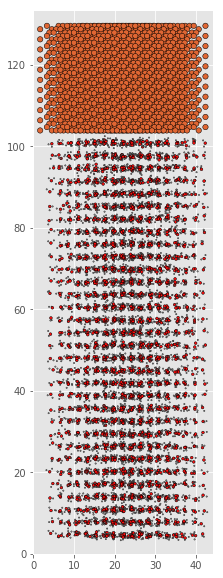

In [5]:
#style.use('dark_background')
style.use('ggplot')
figure(figsize=(18, 10))
plot_atoms(Fe_bcc111_l40_aq, radii=0.5, rotation=('90x,45y,0z'))
#Fe_bcc111_l40_aq.write(sim_path + "fe_aq/Fe_bcc111_l40_aq.extxyz")
show()

In [4]:
#Fe_bcc111_l40_aq_efields = [2.0]

In [4]:
Fe_bcc111_l40_aq_efields = arange(0.2, 0.6, 0.1) # V/A = 100MV/cm => 0 MV/cm to 45 MV/cm
Fe_bcc111_l40_aq_names = ['Fe_bcc111_l40_aq_efield_{0:.0f}MVcm'.format(x*100) for x in Fe_bcc111_l40_aq_efields]
Fe_bcc111_l40_aq_names

['Fe_bcc111_l40_aq_efield_20MVcm',
 'Fe_bcc111_l40_aq_efield_30MVcm',
 'Fe_bcc111_l40_aq_efield_40MVcm',
 'Fe_bcc111_l40_aq_efield_50MVcm']

In [5]:
for sim, efield in zip(Fe_bcc111_l40_aq_names, Fe_bcc111_l40_aq_efields):
    calc = reaxff_params_generator(Fe_bcc111_l40_aq, sim, write=True,
                                   input_fd=sim_path + "fe_aq/",
                                   run=400000,
                                   timestep=0.25,
                                   fix=["all_npt all npt temp 300.0 300.0 100.0 xy 1.0 1.0 1000.0",
                                        "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c",
                                        "elec all efield 0.0 0.0 {0:.2f}".format(efield),
                                        "reax_info all reax/c/bonds 10 bonds.tatb",
                                        "zwalls all wall/reflect zlo EDGE zhi EDGE",])

In [6]:
Fe_bcc111_l40_aq_potential = 'ffield.reax.Fe_O_C_H_combined'
Fe_bcc111_l40_aq_input = ["{0}.lammpsin".format(x) for x in Fe_bcc111_l40_aq_names]
Fe_bcc111_l40_aq_commands = ["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 8 -in {0} -screen none\n".format(x) for x in Fe_bcc111_l40_aq_input]
Fe_bcc111_l40_aq_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(Fe_bcc111_l40_aq_potential),
                                 '$PBS_O_WORKDIR/'+x+".lammps*"] for x in Fe_bcc111_l40_aq_names]

Fe_bcc111_l40_aq_PBS = PBS_Submitter(job_names=Fe_bcc111_l40_aq_names,
                                     job_commands=Fe_bcc111_l40_aq_commands,
                                     modules=["mpi", "lammps/11Aug17", "intel-suite/2017"],
                                     walltime="48:00:00",
                                     proc_nodes=1,
                                     proc_cpus=32, #mpiprocs x threads = cpus
                                     proc_mpiprocs=4, 
                                     proc_threads=8,
                                     memory=24,
                                     source_files=Fe_bcc111_l40_aq_source_files)

In [7]:
curr_dir = os.getcwd()
os.chdir(sim_path + "fe_aq")

Fe_bcc111_l40_aq_out, Fe_bcc111_l40_aq_err = Fe_bcc111_l40_aq_PBS.run()

os.chdir(curr_dir)

In [12]:
qstat_monitor(Fe_bcc111_l40_aq_out)

           JobID        Job Name            User         Runtime          Status           Queue
     2162685.cx1 Fe_bcc111_l40_a          yx6015        01:44:11            Done    v1_general24


In [12]:
Fe_bcc111_l40_aq_out

['2163226.cx1']

In [40]:
# Move all the log and error files over to the jobs directory
!mv {sim_path}fe_aq/Fe_bcc111_l10_aq_300K.* {cx1_out}{Fe_bcc111_l10_aq_out[0]}/

mv: cannot stat ‘/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/fe_aq/Fe_bcc111_l10_aq_300K.*’: No such file or directory


In [24]:
# Converting lammpstrj to ase traj
Fe_bcc111_l10_aq_calc.trajectory_out = Trajectory(sim_path + "fe_aq/Fe_bcc111_l10_aq.traj", 'w')
Fe_bcc111_l10_aq_calc.read_lammps_trj(lammps_trj = cx1_out + Fe_bcc111_l10_aq_out[0] + r"/Fe_bcc111_l10_aq.lammpstrj")
Fe_bcc111_l10_aq_calc.trajectory_out.close()